## Library 

In [1]:
import librosa
import os
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

import copy
from transformers import AutoProcessor, Data2VecAudioModel
from transformers import AutoTokenizer, Data2VecTextModel
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from datasets import load_dataset, Audio
import datasets
import glob
import collections
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

## Function

In [2]:
def make_ts_dataframe(session_num):
# session_num : from 1 to 40
    if session_num <= 9:
        dir_path = '/home/arplab/project/paradeigma/multi_modal/org_KEMDy20/Session0' + str(session_num)
        target_path = dir_path + '/Session0' + str(session_num) + '.csv'
    
    else:
        dir_path = '/home/arplab/project/paradeigma/multi_modal/org_KEMDy20/Session' + str(session_num)
        target_path = dir_path + '/Session' + str(session_num) + '.csv'
        
    ts_data_frame = pd.read_csv(target_path)
    ts_data_frame = ts_data_frame.rename(columns={'acc' : 'eda'})
    ts_data_frame = ts_data_frame.drop(['timestamp'], axis = 1)
    ts_data_frame = ts_data_frame.astype({'eda':'object', 'temp':'object', 'ibi':'object'})
    
    return ts_data_frame

def make_ts_original_sid(session_num):
    if session_num <= 9:
        target_path = '/home/arplab/project/paradeigma/multi_modal/org_KEMDy20/annotation/Sess0' + str(session_num) + '_eval.csv'
    
    else:
        target_path = '/home/arplab/project/paradeigma/multi_modal/org_KEMDy20/annotation/Sess' + str(session_num) + '_eval.csv'
    
    anno_df = pd.read_csv(target_path)
    return list(anno_df['Segment ID'][1:].values)
    
    
def make_target_dataframe(session_num):
# session_num : from 1 to 40

    if session_num <= 9:
        target_path = '/home/arplab/project/paradeigma/multi_modal/org_KEMDy20/annotation/Sess0' + str(session_num) + '_eval.csv'
    
    else:
        target_path = '/home/arplab/project/paradeigma/multi_modal/org_KEMDy20/annotation/Sess' + str(session_num) + '_eval.csv'

    train = pd.read_csv(target_path)
    train = train[['Segment ID', 'Total Evaluation',' .1',' .2']]
    train.columns = ['segment_id','emotion','valence','arousal']
    train = train.drop([0], axis = 0)
    train = train.sort_values('segment_id', ascending=True)
    train['eda'] = 0
    train['temp'] = 0
    train['ibi'] = 0
    train = train.astype({'eda':'object', 'temp':'object', 'ibi':'object'})
    train = train.reset_index(drop=True)
    
    return train

def make_target_dict(num_sessions):
# num_sessions : from 1 to 40

    target_dict = {}
    for i in tqdm(range(1, num_sessions + 1)):
        target_data = {}
        target_dataframe = make_target_dataframe(i)
        columns = target_dataframe.columns
        
        for j in columns:
            target_data[j] = target_dataframe[j]

        target_dict[i] = target_data
        
# target_dict = {1:{segment_id:_,emotion:_,valence:_, arousal:_}, ..., 40: {segment_id:_,emotion:_,valence:_, arousal:_}}        
    return target_dict

def make_list(x):
    if type(x) != type([]):
        return []
    
    else: 
        return x
   
def from_array_to_list(x):
    if type(x) != type(np.array([])):
        return x
    
    else: 
        return x.tolist()

def sequence_difference(ts_list):
    if type(ts_list) != type([]):
        return ts_list
    
    else : 
        
        ts_df = pd.DataFrame(ts_list)
        result = ts_df.diff()[1:].values
        result = result.reshape(len(result),) 
             
        return result

## Target & TimeSeriese

In [3]:
target_data_frames = {}
num_sessions = 40

for i in range(num_sessions):
    target_data_frames[i+1] = make_target_dataframe(i+1)

In [4]:
num_sessions = 40

target_data_frames = {}
for i in range(num_sessions):
    target_data_frames[i+1] = make_target_dataframe(i + 1)


In [5]:
segment_ids = {}
for i in range(num_sessions):
    segment_id = target_data_frames[i+1]['segment_id']
    segment_ids[i+1] = segment_id

In [6]:
ts_data_frames = {}
for i in range(num_sessions):
    ts_data_frames[i+1] = make_ts_dataframe(i + 1)

## Allocating Ts_Data to Annotation

In [7]:
for session in tqdm(range(num_sessions)):
    for segment in range(len(segment_ids[session+1])):
        eda = ts_data_frames[session+1][ts_data_frames[session+1]['sid'] == segment_ids[session+1][segment]]['eda'].dropna(axis=0).values
        temp = ts_data_frames[session+1][ts_data_frames[session+1]['sid'] == segment_ids[session+1][segment]]['temp'].dropna(axis=0).values
        ibi = ts_data_frames[session+1][ts_data_frames[session+1]['sid'] == segment_ids[session+1][segment]]['ibi'].dropna(axis=0).values
        
        if len(list(eda)) == 0:
            target_data_frames[session+1]['eda'].iloc[segment] = np.NaN
        else: 
            target_data_frames[session+1]['eda'].iloc[segment] = list(eda)
            
        if len(list(temp)) == 0:
            target_data_frames[session+1]['temp'].iloc[segment] = np.NaN
        else: 
            target_data_frames[session+1]['temp'].iloc[segment] = list(temp)
            
        if len(list(ibi)) == 0:
            target_data_frames[session+1]['ibi'].iloc[segment] = np.NaN
        else: 
            target_data_frames[session+1]['ibi'].iloc[segment] = list(ibi)
            


100%|██████████| 40/40 [00:45<00:00,  1.14s/it]


## Ordering According to Annotation

In [8]:
for session in tqdm(range(num_sessions)):
    for segment in range(len(make_ts_original_sid(session+1))):
        temp_row = target_data_frames[session+1][target_data_frames[session+1]['segment_id'] == make_ts_original_sid(session+1)[segment]]
        temp_index = int(target_data_frames[session+1][target_data_frames[session+1]['segment_id'] == make_ts_original_sid(session+1)[segment]].index.values)
        target_data_frames[session+1] = target_data_frames[session+1].drop([temp_index])
        target_data_frames[session+1] = target_data_frames[session+1].append(temp_row)
        target_data_frames[session+1] = target_data_frames[session+1].reset_index(drop=True)

100%|██████████| 40/40 [02:08<00:00,  3.20s/it]


## Deleting Missing Datas

In [9]:
missing_eda_count = 0
missing_eda_session = []
missing_eda_coord = []
for session in range(num_sessions):
    if target_data_frames[session+1]['eda'].isna().sum() != 0:
        missing_eda_count += target_data_frames[session+1]['eda'].isna().sum()
        missing_eda_session.append(session+1)
        
missing_temp_count = 0
missing_temp_session = []
for session in range(num_sessions):
    if target_data_frames[session+1]['temp'].isna().sum() != 0:
        missing_temp_count += target_data_frames[session+1]['temp'].isna().sum()
        missing_temp_session.append(session+1)
        
missing_ibi_count = 0
missing_ibi_session = []
for session in range(num_sessions):
    if target_data_frames[session+1]['ibi'].isna().sum() != 0:
        missing_ibi_count += target_data_frames[session+1]['ibi'].isna().sum()
        missing_ibi_session.append(session+1)
    

In [10]:
print("Session of Missing EDA Datas: ", missing_eda_session)
print("Numbers of Missing EDA Datas: ", missing_eda_count)
print("-"*30)
print("Session of Missing Temp Datas: ", missing_temp_session)
print("Numbers of Missing Temp Datas: ", missing_temp_count)
print("-"*30)
print("Session of Missing IBI Datas: ", missing_ibi_session)
print("Numbers of Missing IBI Datas: ", missing_ibi_count)
print("-"*30)

Session of Missing EDA Datas:  [12, 17, 18, 36, 38, 39]
Numbers of Missing EDA Datas:  747
------------------------------
Session of Missing Temp Datas:  [12, 17, 18, 36, 38, 39]
Numbers of Missing Temp Datas:  747
------------------------------
Session of Missing IBI Datas:  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40]
Numbers of Missing IBI Datas:  3875
------------------------------


In [11]:
missing_eda_dict = {}
for missing_session in missing_eda_session:
    missing_index = target_data_frames[missing_session]['eda'][target_data_frames[missing_session]['eda'].isna()].index
    missing_eda_dict[missing_session] = missing_index
    
missing_temp_dict = {}
for missing_session in missing_temp_session:
    missing_index = target_data_frames[missing_session]['temp'][target_data_frames[missing_session]['temp'].isna()].index
    missing_temp_dict[missing_session] = missing_index
    
missing_ibi_dict = {}
for missing_session in missing_ibi_session:
    missing_index = target_data_frames[missing_session]['eda'][target_data_frames[missing_session]['eda'].isna()].index
    missing_ibi_dict[missing_session] = missing_index

## Length of Timeseries

In [12]:
eda_len = []
temp_len = []
ibi_len = []

eda_len_dict = {}
temp_len_dict = {}
ibi_len_dict = {}
for session in tqdm(range(num_sessions)):
    eda_list = []
    temp_list = []
    ibi_list = []
    for segment in range(len(segment_ids[session+1])):
        eda_len.append(len(target_data_frames[session+1]['eda'].apply(make_list)[segment]))
        temp_len.append(len(target_data_frames[session+1]['temp'].apply(make_list)[segment]))
        ibi_len.append(len(target_data_frames[session+1]['ibi'].apply(make_list)[segment]))
        
        eda_list.append(len(target_data_frames[session+1]['eda'].apply(make_list)[segment]))
        temp_list.append(len(target_data_frames[session+1]['temp'].apply(make_list)[segment]))
        ibi_list.append(len(target_data_frames[session+1]['ibi'].apply(make_list)[segment]))
        
    eda_len_dict[session] = eda_list
    temp_len_dict[session] = temp_list
    ibi_len_dict[session] = ibi_list

100%|██████████| 40/40 [00:21<00:00,  1.89it/s]


In [13]:
target_data_frames[1]

,segment_id,emotion,valence,arousal,eda,temp,ibi
0,Sess01_script01_User002M_001,neutral,3.4,2.9,"[2.856493, 2.788578, 2.678377, 2.652749, 2.645...","[34.81, 34.81, 34.81, 34.79, 34.79, 34.79, 34....",NaN
1,Sess01_script01_User002M_002,neutral,3.1,2.9,"[2.647035, 2.653442, 2.631658, 2.614999, 2.623...","[34.79, 34.79, 34.79, 34.77, 34.77, 34.77, 34....","[0.65625, 0.609375, 0.609375]"
2,Sess01_script01_User002M_003,neutral,3.1,3,"[2.896217, 2.975664, 3.02692, 3.071769, 3.0922...","[34.75, 34.75, 34.75, 34.75, 34.79, 34.79, 34....",NaN
3,Sess01_script01_User002M_004,neutral,3.7,3.1,"[3.689019, 3.692863, 3.659546, 3.409672, 3.123...","[34.77, 34.77, 34.77, 34.77, 34.77, 34.77, 34....",NaN
4,Sess01_script01_User001F_001,neutral,3.8,2.8,"[4.412055, 4.536246, 4.630991, 4.669401, 4.661...","[34.55, 34.55, 34.55, 34.55, 34.55, 34.55, 34....","[0.640625, 0.640625, 0.578125]"
...,...,...,...,...,...,...,...
306,Sess01_script06_User001F_016,neutral,3.3,3.5,"[7.580053, 7.586454, 7.576212, 7.606938, 7.660...","[34.43, 34.43, 34.43, 34.43, 34.43, 34.41, 34....",NaN
307,Sess01_script06_User002M_041,neutral,3.3,3.1,"[2.955339, 2.959184, 2.951495, 3.009162, 3.164...","[36.05, 36.05, 36.05, 36.05, 36.03, 36.03, 36....",NaN
308,Sess01_script06_User002M_042,neutral,3,2.9,"[3.215091, 3.277884, 3.297106, 3.225343, 3.151...","[36.07, 36.07, 36.07, 36.07, 36.05, 36.05, 36....",NaN
309,Sess01_script06_User002M_043,neutral,3,2.7,"[3.250973, 3.240721, 3.236876, 3.225343, 3.21381]","[36.07, 36.05, 36.05, 36.05, 36.05]",NaN


In [75]:
length_df = pd.DataFrame({'eda' : eda_len, 'temp' : temp_len, 'ibi' : ibi_len})
length_df['index'] = length_df.index

In [76]:
length_df

,eda,temp,ibi,index
0,32,32,0,0
1,47,47,3,1
2,33,33,0,2
3,45,45,0,3
4,9,9,3,4
...,...,...,...,...
13457,22,22,7,13457
13458,10,10,3,13458
13459,27,27,9,13459
13460,11,11,3,13460


In [77]:
length_df.describe()

,eda,temp,ibi,index
count,13462.000000,13462.000000,13462.000000,13462.000000
mean,22.316075,22.316075,4.944510,6730.500000
std,17.774826,17.774826,5.759844,3886.288997
min,0.000000,0.000000,0.000000,0.000000
25%,10.000000,10.000000,0.000000,3365.250000
50%,17.000000,17.000000,3.000000,6730.500000
75%,30.000000,30.000000,7.000000,10095.750000
max,141.000000,141.000000,68.000000,13461.000000


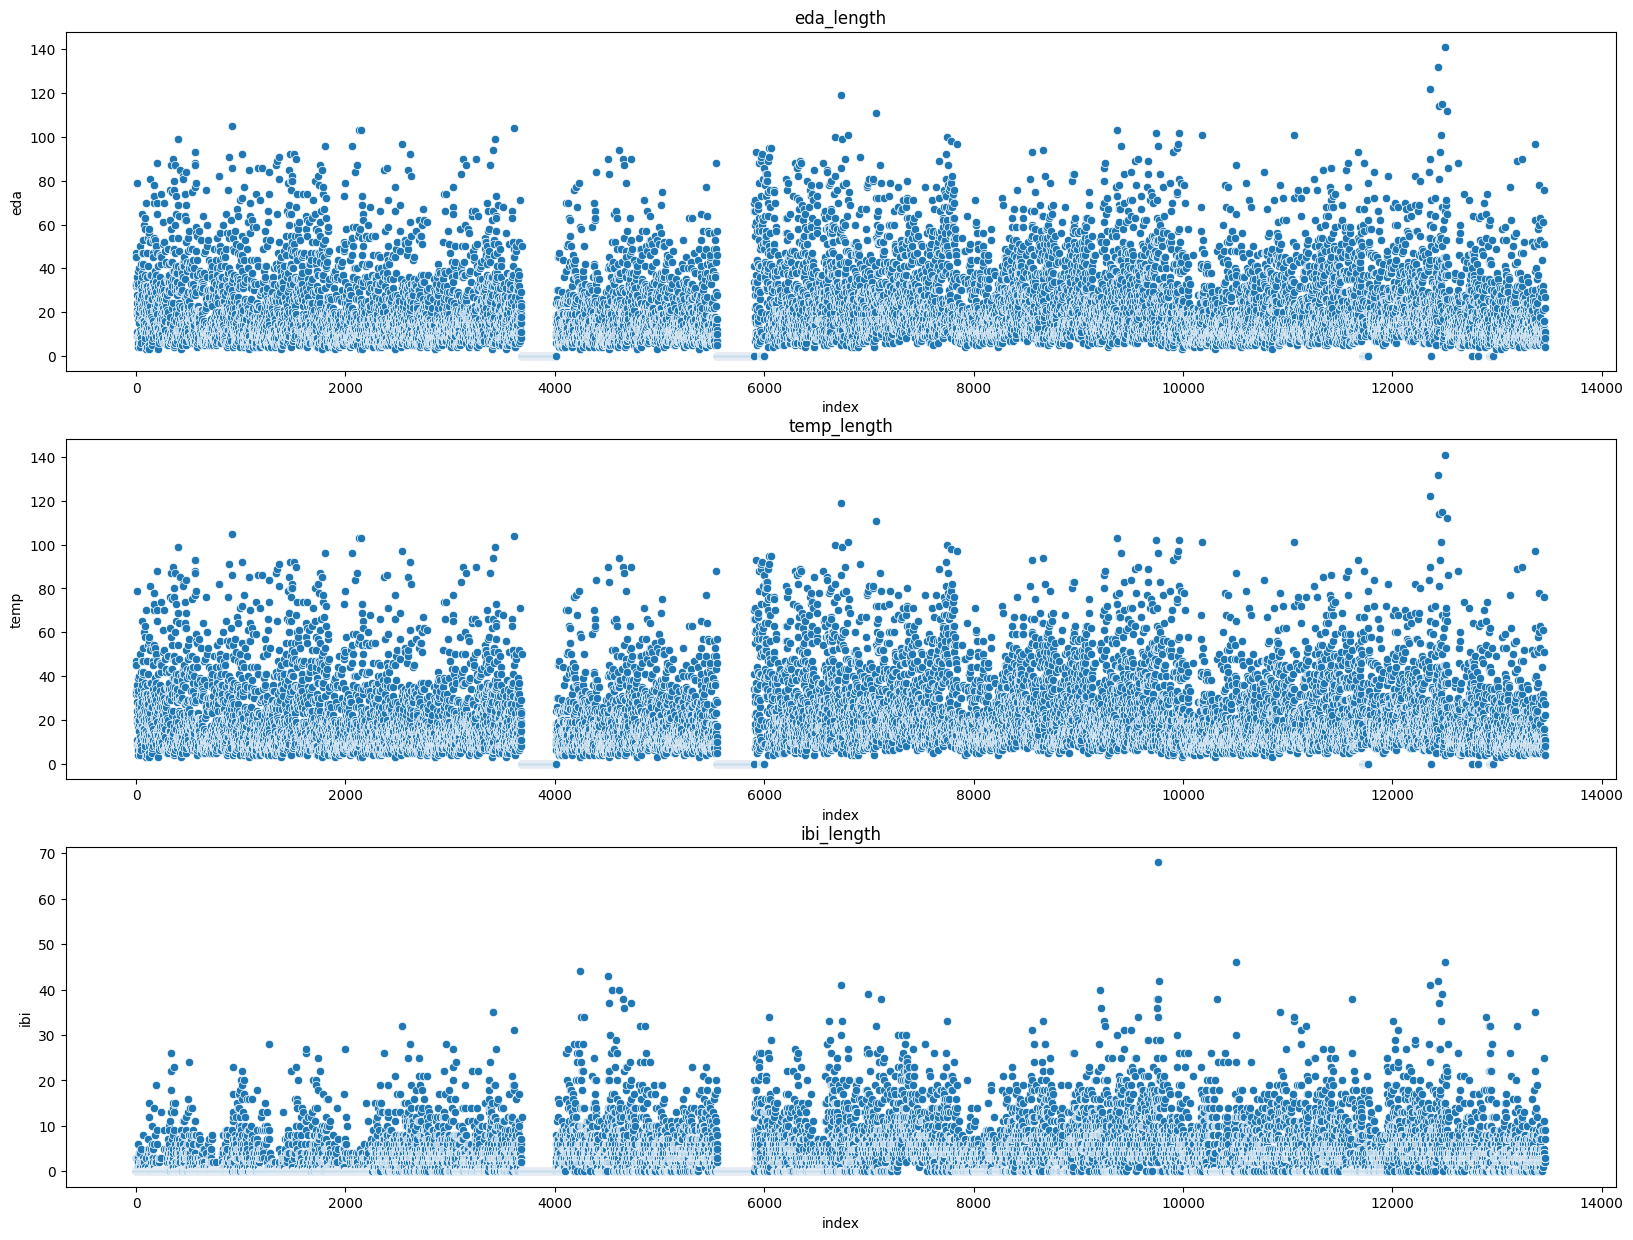

In [78]:
plt.figure(figsize = (20,15))

plt.subplot(3,1,1)
plt.title('eda_length')
sns.scatterplot(data=length_df, x='index', y = 'eda')

plt.subplot(3,1,2)
plt.title('temp_length')
sns.scatterplot(data=length_df, x='index', y = 'temp')

plt.subplot(3,1,3)
plt.title('ibi_length')
sns.scatterplot(data=length_df, x='index', y = 'ibi')
plt.show()

In [80]:
target_data_frames[1]

,segment_id,emotion,valence,arousal,eda,temp,ibi
0,Sess01_script01_User002M_001,neutral,3.4,2.9,"[2.856493, 2.788578, 2.678377, 2.652749, 2.645...","[34.81, 34.81, 34.81, 34.79, 34.79, 34.79, 34....",NaN
1,Sess01_script01_User002M_002,neutral,3.1,2.9,"[2.647035, 2.653442, 2.631658, 2.614999, 2.623...","[34.79, 34.79, 34.79, 34.77, 34.77, 34.77, 34....","[0.65625, 0.609375, 0.609375]"
2,Sess01_script01_User002M_003,neutral,3.1,3,"[2.896217, 2.975664, 3.02692, 3.071769, 3.0922...","[34.75, 34.75, 34.75, 34.75, 34.79, 34.79, 34....",NaN
3,Sess01_script01_User002M_004,neutral,3.7,3.1,"[3.689019, 3.692863, 3.659546, 3.409672, 3.123...","[34.77, 34.77, 34.77, 34.77, 34.77, 34.77, 34....",NaN
4,Sess01_script01_User001F_001,neutral,3.8,2.8,"[4.412055, 4.536246, 4.630991, 4.669401, 4.661...","[34.55, 34.55, 34.55, 34.55, 34.55, 34.55, 34....","[0.640625, 0.640625, 0.578125]"
...,...,...,...,...,...,...,...
306,Sess01_script06_User001F_016,neutral,3.3,3.5,"[7.580053, 7.586454, 7.576212, 7.606938, 7.660...","[34.43, 34.43, 34.43, 34.43, 34.43, 34.41, 34....",NaN
307,Sess01_script06_User002M_041,neutral,3.3,3.1,"[2.955339, 2.959184, 2.951495, 3.009162, 3.164...","[36.05, 36.05, 36.05, 36.05, 36.03, 36.03, 36....",NaN
308,Sess01_script06_User002M_042,neutral,3,2.9,"[3.215091, 3.277884, 3.297106, 3.225343, 3.151...","[36.07, 36.07, 36.07, 36.07, 36.05, 36.05, 36....",NaN
309,Sess01_script06_User002M_043,neutral,3,2.7,"[3.250973, 3.240721, 3.236876, 3.225343, 3.21381]","[36.07, 36.05, 36.05, 36.05, 36.05]",NaN


In [4]:
import torch

/home/arplab/project/paradeigma/multi_modal/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
a = torch.tensor([1,2,3])
b = torch.tensor([4,5,6])
c = torch.tensor([7, 8, 9])

In [24]:
import numpy as np

a = np.ones((2,1,1)) + 1
b = np.ones((1,5,1)) + 2
c = np.ones((1,1,7)) + 2

In [26]:
np.outer(np.outer(a,b), c).shape

(10, 7)

In [21]:
torch.outer(a,b)

TypeError: outer(): argument 'input' (position 1) must be Tensor, not numpy.ndarray

In [10]:
torch.outer(torch.outer(a,b), c) 

RuntimeError: outer: Expected 1-D argument self, but got 2-D

In [14]:
for session in tqdm(range(num_sessions)):
    for segment in range(len(target_data_frames[session+1])):
        target_data_frames[session+1]['eda']=target_data_frames[session+1]['eda'].apply(sequence_difference)

100%|██████████| 40/40 [00:07<00:00,  5.53it/s]


In [15]:
target_data_frames[1]

,segment_id,emotion,valence,arousal,eda,temp,ibi
0,Sess01_script01_User002M_001,neutral,3.4,2.9,"[-0.06791500000000017, -0.110201, -0.025627999...","[34.81, 34.81, 34.81, 34.79, 34.79, 34.79, 34....",NaN
1,Sess01_script01_User002M_002,neutral,3.1,2.9,"[0.006407000000000274, -0.021784000000000248, ...","[34.79, 34.79, 34.79, 34.77, 34.77, 34.77, 34....","[0.65625, 0.609375, 0.609375]"
2,Sess01_script01_User002M_003,neutral,3.1,3,"[0.07944700000000005, 0.05125599999999997, 0.0...","[34.75, 34.75, 34.75, 34.75, 34.79, 34.79, 34....",NaN
3,Sess01_script01_User002M_004,neutral,3.7,3.1,"[0.0038439999999999586, -0.03331699999999982, ...","[34.77, 34.77, 34.77, 34.77, 34.77, 34.77, 34....",NaN
4,Sess01_script01_User001F_001,neutral,3.8,2.8,"[0.1241910000000006, 0.09474499999999964, 0.03...","[34.55, 34.55, 34.55, 34.55, 34.55, 34.55, 34....","[0.640625, 0.640625, 0.578125]"
...,...,...,...,...,...,...,...
306,Sess01_script06_User001F_016,neutral,3.3,3.5,"[0.006400999999999435, -0.010241999999999862, ...","[34.43, 34.43, 34.43, 34.43, 34.43, 34.41, 34....",NaN
307,Sess01_script06_User002M_041,neutral,3.3,3.1,"[0.0038450000000000983, -0.007689000000000057,...","[36.05, 36.05, 36.05, 36.05, 36.03, 36.03, 36....",NaN
308,Sess01_script06_User002M_042,neutral,3,2.9,"[0.06279299999999965, 0.019222000000000072, -0...","[36.07, 36.07, 36.07, 36.07, 36.05, 36.05, 36....",NaN
309,Sess01_script06_User002M_043,neutral,3,2.7,"[-0.010251999999999928, -0.0038450000000000983...","[36.07, 36.05, 36.05, 36.05, 36.05]",NaN


In [16]:
for session in tqdm(range(num_sessions)):
    target_data_frames[session+1]['eda'] = target_data_frames[session+1]['eda'].apply(from_array_to_list)

100%|██████████| 40/40 [00:00<00:00, 953.71it/s]


In [17]:
target_data_frames[1]

,segment_id,emotion,valence,arousal,eda,temp,ibi
0,Sess01_script01_User002M_001,neutral,3.4,2.9,"[-0.06791500000000017, -0.110201, -0.025627999...","[34.81, 34.81, 34.81, 34.79, 34.79, 34.79, 34....",NaN
1,Sess01_script01_User002M_002,neutral,3.1,2.9,"[0.006407000000000274, -0.021784000000000248, ...","[34.79, 34.79, 34.79, 34.77, 34.77, 34.77, 34....","[0.65625, 0.609375, 0.609375]"
2,Sess01_script01_User002M_003,neutral,3.1,3,"[0.07944700000000005, 0.05125599999999997, 0.0...","[34.75, 34.75, 34.75, 34.75, 34.79, 34.79, 34....",NaN
3,Sess01_script01_User002M_004,neutral,3.7,3.1,"[0.0038439999999999586, -0.03331699999999982, ...","[34.77, 34.77, 34.77, 34.77, 34.77, 34.77, 34....",NaN
4,Sess01_script01_User001F_001,neutral,3.8,2.8,"[0.1241910000000006, 0.09474499999999964, 0.03...","[34.55, 34.55, 34.55, 34.55, 34.55, 34.55, 34....","[0.640625, 0.640625, 0.578125]"
...,...,...,...,...,...,...,...
306,Sess01_script06_User001F_016,neutral,3.3,3.5,"[0.006400999999999435, -0.010241999999999862, ...","[34.43, 34.43, 34.43, 34.43, 34.43, 34.41, 34....",NaN
307,Sess01_script06_User002M_041,neutral,3.3,3.1,"[0.0038450000000000983, -0.007689000000000057,...","[36.05, 36.05, 36.05, 36.05, 36.03, 36.03, 36....",NaN
308,Sess01_script06_User002M_042,neutral,3,2.9,"[0.06279299999999965, 0.019222000000000072, -0...","[36.07, 36.07, 36.07, 36.07, 36.05, 36.05, 36....",NaN
309,Sess01_script06_User002M_043,neutral,3,2.7,"[-0.010251999999999928, -0.0038450000000000983...","[36.07, 36.05, 36.05, 36.05, 36.05]",NaN


In [ ]:
import pickle

with open('../model/data/paradeigma_ts_data_preprocessing.pkl', 'wb') as f:
    pickle.dump(target_data_frames, f, pickle.HIGHEST_PROTOCOL)

In [1]:
import pickle

with open('../model/data/paradeigma_ts_data_preprocessing.pkl', 'rb') as f:
    target_data_frames = pickle.load(f)

In [2]:
target_data_frames[1]

,segment_id,emotion,valence,arousal,eda,temp,ibi
0,Sess01_script01_User002M_001,neutral,3.4,2.9,"[-0.06791500000000017, -0.110201, -0.025627999...","[34.81, 34.81, 34.81, 34.79, 34.79, 34.79, 34....",NaN
1,Sess01_script01_User002M_002,neutral,3.1,2.9,"[0.006407000000000274, -0.021784000000000248, ...","[34.79, 34.79, 34.79, 34.77, 34.77, 34.77, 34....","[0.65625, 0.609375, 0.609375]"
2,Sess01_script01_User002M_003,neutral,3.1,3,"[0.07944700000000005, 0.05125599999999997, 0.0...","[34.75, 34.75, 34.75, 34.75, 34.79, 34.79, 34....",NaN
3,Sess01_script01_User002M_004,neutral,3.7,3.1,"[0.0038439999999999586, -0.03331699999999982, ...","[34.77, 34.77, 34.77, 34.77, 34.77, 34.77, 34....",NaN
4,Sess01_script01_User001F_001,neutral,3.8,2.8,"[0.1241910000000006, 0.09474499999999964, 0.03...","[34.55, 34.55, 34.55, 34.55, 34.55, 34.55, 34....","[0.640625, 0.640625, 0.578125]"
...,...,...,...,...,...,...,...
306,Sess01_script06_User001F_016,neutral,3.3,3.5,"[0.006400999999999435, -0.010241999999999862, ...","[34.43, 34.43, 34.43, 34.43, 34.43, 34.41, 34....",NaN
307,Sess01_script06_User002M_041,neutral,3.3,3.1,"[0.0038450000000000983, -0.007689000000000057,...","[36.05, 36.05, 36.05, 36.05, 36.03, 36.03, 36....",NaN
308,Sess01_script06_User002M_042,neutral,3,2.9,"[0.06279299999999965, 0.019222000000000072, -0...","[36.07, 36.07, 36.07, 36.07, 36.05, 36.05, 36....",NaN
309,Sess01_script06_User002M_043,neutral,3,2.7,"[-0.010251999999999928, -0.0038450000000000983...","[36.07, 36.05, 36.05, 36.05, 36.05]",NaN


In [86]:
num_sessions = 40

In [87]:
missing_eda_count = 0
missing_eda_session = []
missing_eda_coord = []
for session in range(num_sessions):
    if target_data_frames[session+1]['eda'].isna().sum() != 0:
        missing_eda_count += target_data_frames[session+1]['eda'].isna().sum()
        missing_eda_session.append(session+1)
        
missing_temp_count = 0
missing_temp_session = []
for session in range(num_sessions):
    if target_data_frames[session+1]['temp'].isna().sum() != 0:
        missing_temp_count += target_data_frames[session+1]['temp'].isna().sum()
        missing_temp_session.append(session+1)
        
missing_ibi_count = 0
missing_ibi_session = []
for session in range(num_sessions):
    if target_data_frames[session+1]['ibi'].isna().sum() != 0:
        missing_ibi_count += target_data_frames[session+1]['ibi'].isna().sum()
        missing_ibi_session.append(session+1)
    

In [88]:
print("Session of Missing EDA Datas: ", missing_eda_session)
print("Numbers of Missing EDA Datas: ", missing_eda_count)
print("-"*30)
print("Session of Missing Temp Datas: ", missing_temp_session)
print("Numbers of Missing Temp Datas: ", missing_temp_count)
print("-"*30)
print("Session of Missing IBI Datas: ", missing_ibi_session)
print("Numbers of Missing IBI Datas: ", missing_ibi_count)
print("-"*30)

Session of Missing EDA Datas:  [12, 17, 18, 36, 38, 39]
Numbers of Missing EDA Datas:  747
------------------------------
Session of Missing Temp Datas:  [12, 17, 18, 36, 38, 39]
Numbers of Missing Temp Datas:  747
------------------------------
Session of Missing IBI Datas:  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40]
Numbers of Missing IBI Datas:  3875
------------------------------


In [89]:
missing_eda_dict = {}
for missing_session in missing_eda_session:
    missing_index = target_data_frames[missing_session]['eda'][target_data_frames[missing_session]['eda'].isna()].index
    missing_eda_dict[missing_session] = missing_index
    
missing_temp_dict = {}
for missing_session in missing_temp_session:
    missing_index = target_data_frames[missing_session]['temp'][target_data_frames[missing_session]['temp'].isna()].index
    missing_temp_dict[missing_session] = missing_index
    
missing_ibi_dict = {}
for missing_session in missing_ibi_session:
    missing_index = target_data_frames[missing_session]['eda'][target_data_frames[missing_session]['eda'].isna()].index
    missing_ibi_dict[missing_session] = missing_index

In [90]:
from tqdm import tqdm

In [91]:
for session in tqdm(range(num_sessions)):
    for segment in range(len(target_data_frames[session+1])):
        try: target_data_frames[session+1] = target_data_frames[session+1].drop(['ibi'], axis=1)
        except: pass
        target_data_frames[session+1] = target_data_frames[session+1].dropna()
        target_data_frames[session+1] = target_data_frames[session+1].reset_index(drop=True)

100%|██████████| 40/40 [00:14<00:00,  2.77it/s]


In [92]:
def sequence_padding(ts_list, padding_length = 50, mode = 'constant'):
    
    padding_value=0
    
    if (type(ts_list) != type([])) :
        ts_list = [padding_value] * padding_length
    
    elif len(ts_list) >= padding_length :
        ts_list = ts_list[0:padding_length]
    
    elif mode == 'constant':
        length = padding_length - len(ts_list)
        extend_list = [padding_value] * length
        ts_list = ts_list + extend_list    
        
    elif mode == 'replicate':
        
        quotient = padding_length // len(ts_list)
        remainder = padding_length % len(ts_list)
        result = ts_list * quotient
        result += ts_list[:remainder]
        ts_list = result
        
    return ts_list            

In [93]:
import copy

In [94]:
padded_target_data_frames = copy.deepcopy(target_data_frames)

for session in tqdm(range(num_sessions)):
    padded_target_data_frames[session+1]['eda'] = padded_target_data_frames[session+1]['eda'].apply(sequence_padding, padding_length = 50, mode = 'replicate')
    padded_target_data_frames[session+1]['temp'] = padded_target_data_frames[session+1]['temp'].apply(sequence_padding, padding_length = 50, mode = 'replicate')

100%|██████████| 40/40 [00:00<00:00, 145.56it/s]


In [13]:
# counter = 0
# for session in tqdm(range(num_sessions)):
#     for segment in range(len(padded_target_data_frames[session + 1])):
#         if ((padded_target_data_frames[session + 1]['emotion'][segment] != 'neutral') and
#         (padded_target_data_frames[session + 1]['emotion'][segment] != 'angry') and
#         (padded_target_data_frames[session + 1]['emotion'][segment] != 'happy') and
#         (padded_target_data_frames[session + 1]['emotion'][segment] != 'surprise') and
#         (padded_target_data_frames[session + 1]['emotion'][segment] != 'sad') and
#         (padded_target_data_frames[session + 1]['emotion'][segment] != 'disgust')):
#             counter += 1
        

100%|██████████| 40/40 [00:00<00:00, 263.41it/s]


In [102]:
single_target_dict = {}
for session in range(num_sessions):
    index = []
    for segment in range(len(padded_target_data_frames[session + 1])):
        if padded_target_data_frames[session + 1]['emotion'][segment].count(';') == 0:
            index.append(segment)
    single_target_dict[session+1] = index


In [104]:
padded_target_data_frames[1].iloc[single_target_dict[1]]

,segment_id,emotion,valence,arousal,eda,temp
0,Sess01_script01_User002M_001,neutral,3.4,2.9,"[-0.06791500000000017, -0.110201, -0.025627999...","[34.81, 34.81, 34.81, 34.79, 34.79, 34.79, 34...."
1,Sess01_script01_User002M_002,neutral,3.1,2.9,"[0.006407000000000274, -0.021784000000000248, ...","[34.79, 34.79, 34.79, 34.77, 34.77, 34.77, 34...."
2,Sess01_script01_User002M_003,neutral,3.1,3,"[0.07944700000000005, 0.05125599999999997, 0.0...","[34.75, 34.75, 34.75, 34.75, 34.79, 34.79, 34...."
3,Sess01_script01_User002M_004,neutral,3.7,3.1,"[0.0038439999999999586, -0.03331699999999982, ...","[34.77, 34.77, 34.77, 34.77, 34.77, 34.77, 34...."
4,Sess01_script01_User001F_001,neutral,3.8,2.8,"[0.1241910000000006, 0.09474499999999964, 0.03...","[34.55, 34.55, 34.55, 34.55, 34.55, 34.55, 34...."
...,...,...,...,...,...,...
306,Sess01_script06_User001F_016,neutral,3.3,3.5,"[0.006400999999999435, -0.010241999999999862, ...","[34.43, 34.43, 34.43, 34.43, 34.43, 34.41, 34...."
307,Sess01_script06_User002M_041,neutral,3.3,3.1,"[0.0038450000000000983, -0.007689000000000057,...","[36.05, 36.05, 36.05, 36.05, 36.03, 36.03, 36...."
308,Sess01_script06_User002M_042,neutral,3,2.9,"[0.06279299999999965, 0.019222000000000072, -0...","[36.07, 36.07, 36.07, 36.07, 36.05, 36.05, 36...."
309,Sess01_script06_User002M_043,neutral,3,2.7,"[-0.010251999999999928, -0.0038450000000000983...","[36.07, 36.05, 36.05, 36.05, 36.05, 36.07, 36...."


In [ ]:
single_padded_target_data_frames[]

In [15]:
import sklearn.svm as svm
import sklearn.metrics as mt
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.linear_model import LinearRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import MinMaxScaler

In [20]:
train_eda = []
train_temp = []
target = []

for session in range(num_sessions):
    for segment in range(len(padded_target_data_frames[session+1])):
        train_eda.append(padded_target_data_frames[session+1]['eda'][segment])
        train_temp.append(padded_target_data_frames[session+1]['temp'][segment])
        target.append(padded_target_data_frames[session+1]['emotion'][segment])

In [21]:
len(train_eda), len(train_temp), len(target)

(12715, 12715, 12715)

In [22]:
target_V = []
target_A = []
for session in range(num_sessions):
    for segment in range(len(padded_target_data_frames[session + 1])):
        target_V.append(float(padded_target_data_frames[session+1]['valence'][segment]))
        target_A.append(float(padded_target_data_frames[session+1]['arousal'][segment]))

In [23]:
len(target_V), len(target_A)

(12715, 12715)

In [24]:
unique_emotion_target = list(set(target))
len(unique_emotion_target)

24

In [26]:
import pandas as pd

In [27]:
target_VA_df = pd.DataFrame([target_V, target_A]).T
target_VA_df.columns = ['Vanlence', 'Arousal']
target_VA_df

,Vanlence,Arousal
0,3.4,2.9
1,3.1,2.9
2,3.1,3.0
3,3.7,3.1
4,3.8,2.8
...,...,...
12710,3.0,3.5
12711,2.9,3.1
12712,2.6,3.6
12713,2.7,3.3


In [28]:
# Emotion Encoding

encoded_target = []
for i in range(len(target)):
    for j in range(len(unique_emotion_target)):
        if target[i] == unique_emotion_target[j]:
            encoded_target.append(j)            

In [73]:
scaler = MinMaxScaler()
scaled_target_VA = scaler.fit_transform(target_VA_df)
scaled_target_VA_df = pd.DataFrame(scaled_target_VA)
scaled_target_VA_df.columns = ['Vanlence', 'Arousal']
scaled_target_VA_df['Vanlence']

0        0.580645
1        0.483871
2        0.483871
3        0.677419
4        0.709677
           ...   
12710    0.451613
12711    0.419355
12712    0.322581
12713    0.354839
12714    0.419355
Name: Vanlence, Length: 12715, dtype: float64

In [74]:
torch.tensor(train_eda).shape

torch.Size([12715, 50])

In [75]:
train = torch.concat([torch.tensor(train_eda), torch.tensor(train_temp)], dim=-1)
train.shape

torch.Size([12715, 100])

In [76]:
svm_clf = svm.SVC(kernel = 'linear')
X_train, X_test, y_train, y_test = train_test_split(train, encoded_target, test_size = 0.2, random_state=42)
svm_clf.fit(X_train, y_train)
svm_clf_predictions = svm_clf.predict(X_test)
print("Accuracy: {}%".format(svm_clf.score(X_test, y_test) * 100 ))
print("f1_score: {}%".format(f1_score(y_test, svm_clf_predictions, average='weighted')*100))
print(classification_report(svm_clf_predictions, y_test))

Accuracy: 82.02909948879277%
f1_score: 73.93074164338809%
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.00      0.00      0.00         0
           2       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0
          10       0.00      0.00      0.00         0
          13       0.00      0.00      0.00         0
          14       0.00      0.00      0.00         0
          15       0.00      0.00      0.00         0
          16       0.00      0.00      0.00         0
          17       1.00      0.82      0.90      2543
          18       0.00      0.00      0.00         0
          21       0.00      0.00      0.00         0
          22       0.00      0.00      0.00         0
          23       0.00      0.00      0.00         0

    accuracy                           0.82      2543
   macro avg       0.0

In [77]:
svm_clf = svm.SVC(kernel = 'rbf', C = 10.0, gamma=0.1)
X_train, X_test, y_train, y_test = train_test_split(train, encoded_target, test_size = 0.2, random_state=42)
svm_clf.fit(X_train, y_train)
svm_clf_predictions = svm_clf.predict(X_test)
print("Accuracy: {}%".format(svm_clf.score(X_test, y_test) * 100 ))
print("f1_score: {}%".format(f1_score(y_test, svm_clf_predictions, average='weighted')*100))
print(classification_report(svm_clf_predictions, y_test))

Accuracy: 82.02909948879277%
f1_score: 73.93074164338809%
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.00      0.00      0.00         0
           2       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0
          10       0.00      0.00      0.00         0
          13       0.00      0.00      0.00         0
          14       0.00      0.00      0.00         0
          15       0.00      0.00      0.00         0
          16       0.00      0.00      0.00         0
          17       1.00      0.82      0.90      2543
          18       0.00      0.00      0.00         0
          21       0.00      0.00      0.00         0
          22       0.00      0.00      0.00         0
          23       0.00      0.00      0.00         0

    accuracy                           0.82      2543
   macro avg       0.0

In [84]:
gnb_clf = GaussianNB()
X_train, X_test, y_train, y_test = train_test_split(train, encoded_target, test_size = 0.2, random_state=32)
gnb_clf.fit(X_train, y_train)
gnb_clf_prediction = gnb_clf.predict(X_test)
print("Accuracy: {}%".format(gnb_clf.score(X_test, y_test)))
print("f1_score: {}%".format(f1_score(y_test, gnb_clf_prediction, average='weighted')))
print(classification_report(y_test, gnb_clf_prediction))

Accuracy: 0.007471490365709791%
f1_score: 0.01005586935951765%
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        15
           1       0.01      0.12      0.02        25
           2       0.00      0.12      0.00         8
           3       0.00      0.00      0.00        14
           4       0.00      0.00      0.00         1
           5       0.00      0.00      0.00         1
           9       0.05      0.02      0.03       200
          10       0.00      0.00      0.00        10
          12       0.00      0.00      0.00         0
          14       0.00      0.00      0.00        15
          15       0.00      0.00      0.00        12
          16       0.00      0.00      0.00         0
          17       0.56      0.00      0.01      2107
          18       0.02      0.03      0.02        37
          19       0.00      0.00      0.00         0
          20       0.00      0.00      0.00         1
          21      

In [85]:
ran_clf = RandomForestClassifier(n_estimators=64, max_depth=32,random_state=0)
X_train, X_test, y_train, y_test = train_test_split(train, encoded_target, test_size = 0.2, random_state=42)
ran_clf.fit(X_train,y_train)
ran_clf_prediction = ran_clf.predict(X_test)
print("Accuracy: {}%".format(ran_clf.score(X_test, y_test)))
print("f1_score: {}%".format(f1_score(y_test, ran_clf_prediction, average='weighted')))
print(classification_report(y_test, ran_clf_prediction))

Accuracy: 0.8191112858828156%
f1_score: 0.7387229322747745%
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         9
           1       0.00      0.00      0.00        30
           2       0.00      0.00      0.00         9
           3       0.00      0.00      0.00        13
           9       0.00      0.00      0.00       221
          10       0.00      0.00      0.00        13
          13       0.00      0.00      0.00         1
          14       0.00      0.00      0.00        10
          15       0.00      0.00      0.00        15
          16       0.00      0.00      0.00         1
          17       0.82      1.00      0.90      2086
          18       0.00      0.00      0.00        32
          21       0.00      0.00      0.00        63
          22       0.00      0.00      0.00        36
          23       0.00      0.00      0.00         4

    accuracy                           0.82      2543
   macro avg       0

In [86]:
tree_clf = DecisionTreeClassifier()  
X_train, X_test, y_train, y_test = train_test_split(train, encoded_target, test_size = 0.2, random_state=42)
tree_clf.fit(X_train,y_train)
tree_clf_prediction = tree_clf.predict(X_test)
print("Accuracy: {}%".format(tree_clf.score(X_test, y_test)))
print("f1_score: {}%".format(f1_score(y_test, tree_clf_prediction, average='weighted')))
print(classification_report(y_test, tree_clf_prediction))

Accuracy: 0.6409752261108926%
f1_score: 0.6594396264793356%
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         9
           1       0.00      0.00      0.00        30
           2       0.06      0.11      0.07         9
           3       0.00      0.00      0.00        13
           9       0.11      0.14      0.12       221
          10       0.00      0.00      0.00        13
          12       0.00      0.00      0.00         0
          13       0.00      0.00      0.00         1
          14       0.00      0.00      0.00        10
          15       0.04      0.07      0.05        15
          16       0.00      0.00      0.00         1
          17       0.82      0.77      0.79      2086
          18       0.03      0.03      0.03        32
          21       0.00      0.00      0.00        63
          22       0.03      0.03      0.03        36
          23       0.00      0.00      0.00         4

    accuracy        

In [81]:
line_fitter = LinearRegression()
X_train, X_test, y_train, y_test = train_test_split(train, target_V, test_size = 0.2, random_state=30)
line_fitter.fit(X_train, y_train)
line_fitter_predictions = line_fitter.predict(X_test)
print("r2_score_Valence : ", line_fitter.score(X_test, y_test))
X_train, X_test, y_train, y_test = train_test_split(train, target_A, test_size = 0.2, random_state=30)
line_fitter.fit(X_train, y_train)
line_fitter_predictions = line_fitter.predict(X_test)
print("r2_score_Arousal : ", line_fitter.score(X_test, y_test))

r2_score_Valence :  -0.008278948935884545
r2_score_Arousal :  0.00145399790556211


In [ ]:
conv1 = nn.Conv1d(in_channels=2, out_channels = 1, kernel_size=2, stride=3)

In [ ]:
conv1(test_input).shape

torch.Size([1, 13])

In [ ]:
padded_target_data_frames[1]['eda']

In [ ]:
len(padded_target_data_frames[1]['eda'][0])

40

In [ ]:
conv1(padded_target_data_frames[1]['eda'][0])

TypeError: conv1d() received an invalid combination of arguments - got (list, Parameter, Parameter, tuple, tuple, tuple, int), but expected one of:
 * (Tensor input, Tensor weight, Tensor bias, tuple of ints stride, tuple of ints padding, tuple of ints dilation, int groups)
      didn't match because some of the arguments have invalid types: (!list!, !Parameter!, !Parameter!, !tuple!, !tuple!, !tuple!, int)
 * (Tensor input, Tensor weight, Tensor bias, tuple of ints stride, str padding, tuple of ints dilation, int groups)
      didn't match because some of the arguments have invalid types: (!list!, !Parameter!, !Parameter!, !tuple!, !tuple!, !tuple!, int)


In [ ]:
>>> m = nn.Conv1d(16, 33, 1, stride=1)
>>> input = torch.randn(20, 16, 50)
>>> output = m(input)

In [ ]:
output.shape

torch.Size([20, 33, 50])

In [ ]:
for session in range(num_sessions):
    try : target_data_frames[session+1] = target_data_frames[session+1].drop(['ibi'], axis=1)
    except : pass
    target_data_frames[session+1] = target_data_frames[session+1].dropna(axis=0)

여기까지만 보면 됩니다

In [ ]:
# Session_1 Val, Arou
valence = torch.tensor(target_dict[1]['valence'].astype('float32'))
valence = valence.view(1, valence.size(0))
arousal = torch.tensor(target_dict[1]['arousal'].astype('float32'))
arousal = arousal.view(1, arousal.size(0))
target = torch.concat([valence, arousal])
target_VA = target.T

In [ ]:
# Session_1 Emotion target

target = target_dict[1]['emotion'].copy()
for i in range(len(target_dict[1]['emotion'])):
    if 'happy' in target_dict[1]['emotion'][i]:
        target[i] = 1
        
    elif 'surprise' in target_dict[1]['emotion'][i]:
        target[i] = 2
        
    elif 'angry' in target_dict[1]['emotion'][i]:
        target[i] = 3
        
    elif 'sad' in target_dict[1]['emotion'][i]:
        target[i] = 4
        
    elif 'disgust' in target_dict[1]['emotion'][i]:
        target[i] = 5
        
    elif 'fear' in target_dict[1]['emotion'][i]:
        target[i] = 6
        
    else: 
        target[i] = 0        
        
target = target.astype('float32')
target = target.values
target_E = torch.tensor(target)

In [ ]:
segment_id

['Sess01_script01_User001F_001',
 'Sess01_script01_User001F_002',
 'Sess01_script01_User001F_003',
 'Sess01_script01_User001F_004',
 'Sess01_script01_User001F_005',
 'Sess01_script01_User001F_006',
 'Sess01_script01_User001F_007',
 'Sess01_script01_User001F_008',
 'Sess01_script01_User001F_009',
 'Sess01_script01_User001F_010',
 'Sess01_script01_User001F_011',
 'Sess01_script01_User001F_012',
 'Sess01_script01_User001F_013',
 'Sess01_script01_User001F_014',
 'Sess01_script01_User001F_015',
 'Sess01_script01_User002M_001',
 'Sess01_script01_User002M_002',
 'Sess01_script01_User002M_003',
 'Sess01_script01_User002M_004',
 'Sess01_script01_User002M_005',
 'Sess01_script01_User002M_006',
 'Sess01_script01_User002M_007',
 'Sess01_script01_User002M_008',
 'Sess01_script01_User002M_009',
 'Sess01_script01_User002M_010',
 'Sess01_script01_User002M_011',
 'Sess01_script01_User002M_012',
 'Sess01_script01_User002M_013',
 'Sess01_script01_User002M_014',
 'Sess01_script01_User002M_015',
 'Sess01_s

In [ ]:
segment_id = target_dict[1]['segment_id']
segment_id = sorted(segment_id)


In [ ]:
ts_data_frames[1]

,Unnamed: 0,sid,eda,temp,ibi,emotion,valence,arousal
0,823,Sess01_script01_User001F_002,4.842703,34.59,NaN,neutral,3.3,3.1
1,824,Sess01_script01_User001F_002,4.883674,34.59,NaN,neutral,3.3,3.1
2,825,Sess01_script01_User001F_002,4.872150,34.59,NaN,neutral,3.3,3.1
3,826,Sess01_script01_User001F_002,4.808134,34.59,NaN,neutral,3.3,3.1
4,827,Sess01_script01_User001F_002,4.794051,34.59,NaN,neutral,3.3,3.1
5,828,Sess01_script01_User001F_002,4.773565,34.59,NaN,neutral,3.3,3.1
6,829,Sess01_script01_User001F_002,4.804293,34.59,NaN,neutral,3.3,3.1
7,830,Sess01_script01_User001F_002,4.946410,34.59,NaN,neutral,3.3,3.1
8,831,Sess01_script01_User001F_002,5.144861,34.61,NaN,neutral,3.3,3.1
9,832,Sess01_script01_User001F_002,5.258810,34.61,NaN,neutral,3.3,3.1


In [ ]:
ts_data_frames = {}

for i in range(311):

    ts_data = ts_1[ts_1['sid'] == segment_id[i]]

    ts_target_emotion = target_dict[1]['emotion'][i]
    ts_target_valence = target_dict[1]['valence'][i]
    ts_target_arousal = target_dict[1]['arousal'][i]

    ts_data['emotion'] = ts_target_emotion
    ts_data['valence'] = ts_target_valence
    ts_data['arousal'] = ts_target_arousal
    ts_data = ts_data.reset_index(drop = True, )
    
    ts_data_frames[i] = ts_data

/tmp/ipykernel_1001866/1729593893.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ts_data['emotion'] = ts_target_emotion
/tmp/ipykernel_1001866/1729593893.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ts_data['valence'] = ts_target_valence
/tmp/ipykernel_1001866/1729593893.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas

In [ ]:
target_data_frames[1]

,segment_id,emotion,valence,arousal,eda,temp,ibi
0,Sess01_script01_User001F_001,neutral,3.8,2.8,0,0,0
1,Sess01_script01_User001F_002,neutral,3.3,3.1,0,0,0
2,Sess01_script01_User001F_003,neutral,3.3,3.1,0,0,0
3,Sess01_script01_User001F_004,happy,3.6,3.1,0,0,0
4,Sess01_script01_User001F_005,neutral,3.5,3.2,0,0,0
...,...,...,...,...,...,...,...
306,Sess01_script06_User002M_039,neutral,3,2.8,0,0,0
307,Sess01_script06_User002M_040,neutral,3.4,2.9,0,0,0
308,Sess01_script06_User002M_041,neutral,3.3,3.1,0,0,0
309,Sess01_script06_User002M_042,neutral,3,2.9,0,0,0


In [ ]:
target_data_frames[1]

,segment_id,emotion,valence,arousal
0,Sess01_script01_User001F_001,neutral,3.8,2.8
1,Sess01_script01_User001F_002,neutral,3.3,3.1
2,Sess01_script01_User001F_003,neutral,3.3,3.1
3,Sess01_script01_User001F_004,happy,3.6,3.1
4,Sess01_script01_User001F_005,neutral,3.5,3.2
...,...,...,...,...
306,Sess01_script06_User002M_039,neutral,3,2.8
307,Sess01_script06_User002M_040,neutral,3.4,2.9
308,Sess01_script06_User002M_041,neutral,3.3,3.1
309,Sess01_script06_User002M_042,neutral,3,2.9


In [ ]:
target_data_frames[1]

,segment_id,emotion,valence,arousal
0,Sess01_script01_User001F_001,neutral,3.8,2.8
1,Sess01_script01_User001F_002,neutral,3.3,3.1
2,Sess01_script01_User001F_003,neutral,3.3,3.1
3,Sess01_script01_User001F_004,happy,3.6,3.1
4,Sess01_script01_User001F_005,neutral,3.5,3.2
...,...,...,...,...
306,Sess01_script06_User002M_039,neutral,3,2.8
307,Sess01_script06_User002M_040,neutral,3.4,2.9
308,Sess01_script06_User002M_041,neutral,3.3,3.1
309,Sess01_script06_User002M_042,neutral,3,2.9


In [ ]:
ts_data_frames[310]['eda'].dropna(axis=0)

0    3.250973
1    3.240721
2    3.236876
3    3.225343
4    3.213810
Name: eda, dtype: float64

In [ ]:
target_data_frames[1]['eda'] = ts_data_frames[0]['eda'].dropna(axis=0)
target_data_frames[1]['temp'] = ts_data_frames[0]['temp'].dropna(axis=0)
target_data_frames[1]['ibi'] = ts_data_frames[0]['ibi'].dropna(axis=0)

,segment_id,emotion,valence,arousal
0,Sess01_script01_User001F_001,neutral,3.8,2.8
1,Sess01_script01_User001F_002,neutral,3.3,3.1
2,Sess01_script01_User001F_003,neutral,3.3,3.1
3,Sess01_script01_User001F_004,happy,3.6,3.1
4,Sess01_script01_User001F_005,neutral,3.5,3.2
...,...,...,...,...
306,Sess01_script06_User002M_039,neutral,3,2.8
307,Sess01_script06_User002M_040,neutral,3.4,2.9
308,Sess01_script06_User002M_041,neutral,3.3,3.1
309,Sess01_script06_User002M_042,neutral,3,2.9


In [ ]:
for 

    if ts_data_frames== ts_data_frames[i]['sid'][0]

In [ ]:
ts_data_frames[0]['sid'][0]

'Sess01_script01_User001F_001'

In [ ]:
ts_data_frames[0]['eda'].dropna(axis=0)

0     4.412055
1     4.536246
2     4.630991
4     4.669401
5     4.661719
6     4.654037
7     4.598982
8     4.543929
10    4.510640
Name: eda, dtype: float64